In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")

from electronfactors.model.utilities import *
from electronfactors.model.threshold import fit_give, angle_gap

In [2]:
width, length, eqPonA, factor = pull_data(energy=12)

In [3]:
x = np.array([])
y = np.array([])

In [4]:
low_give_points_number = 3

In [5]:
np.argsort([3,4,5,6,67])

array([0, 1, 2, 3, 4])

In [6]:
def data_reduction_loop(x, y, width, eqPonA, factor, n=1000):
    
    def low_give_loop(reference):
        for i in range(low_give_points_number):
            reference = find_low_give_points(reference)
            
        return reference
    
    def find_low_give_points(reference):
        check = np.setdiff1d(np.arange(len(width)), reference)
        give = np.zeros(len(check))
        gap = np.zeros(len(check))
        
        for i, value in enumerate(check):
            give[i] = fit_give(
                width[value], eqPonA[value], 
                width[reference], eqPonA[reference], factor[reference])
            gap[i] = angle_gap(
                width[value], eqPonA[value], 
                width[reference], eqPonA[reference],
                1, 1)
        
        give[gap>180] = give[gap>180] + 10
        min_give_refs = check[np.argmin(give)]
        result = np.append(reference, min_give_refs)
        return result
    
    for amount in np.arange(8 + low_give_points_number, np.floor(len(width)/2) + 1):        
        order = np.arange(len(width))
        np.random.shuffle(order)
        
        reference = order[0:amount - low_give_points_number]
        reference = low_give_loop(reference)
        uncertainty = prediction_uncertainty(width[reference], eqPonA[reference], factor[reference])
        
        if uncertainty is not(np.nan):
            x = np.append(x, amount)
            y = np.append(y, uncertainty)    
    
    for i in range(n):
        bin_mid = np.arange(np.min(x), np.max(x) + 1)
        bins = np.linspace(np.min(x)-0.5, np.max(x)+0.5, np.ptp(x)+2)
        histogrammed, value = np.histogram(x, bins=bins)
        amount = bin_mid[np.argmin(histogrammed)]
        
        order = np.arange(len(width))
        np.random.shuffle(order)
        
        reference = order[0:amount - low_give_points_number]
        reference = low_give_loop(reference)
        uncertainty = prediction_uncertainty(width[reference], eqPonA[reference], factor[reference])
        
        if uncertainty is not(np.nan):
            x = np.append(x, amount)
            y = np.append(y, uncertainty)
    
    return x, y        

In [7]:
def plot_intervals(x, y):
    amounts = np.arange(np.min(x), np.max(x) + 1)

    upper_interval_3 = np.zeros(len(amounts))
    upper_interval_2 = np.zeros(len(amounts))
    upper_interval_1 = np.zeros(len(amounts))

    lower_interval_1 = np.zeros(len(amounts))
    lower_interval_2 = np.zeros(len(amounts))
    lower_interval_3 = np.zeros(len(amounts))
    
    for i, amount in enumerate(amounts):    
        reference = (x == amount)
        n = np.sum(reference)

        upper_interval_position_3 = np.ceil(n * 0.9985) - 1
        upper_interval_position_2 = np.ceil(n * 0.975) - 1
        upper_interval_position_1 = np.ceil(n * 0.84) - 1

        lower_interval_position_1 = np.floor(n * 0.16) - 1
        lower_interval_position_2 = np.floor(n * 0.025) - 1
        lower_interval_position_3 = np.floor(n * 0.0015) - 1    

        uncertainties_sorted = np.sort(y[reference])

        upper_interval_3[i] = uncertainties_sorted[upper_interval_position_3]
        upper_interval_2[i] = uncertainties_sorted[upper_interval_position_2]
        upper_interval_1[i] = uncertainties_sorted[upper_interval_position_1]

        lower_interval_1[i] = uncertainties_sorted[lower_interval_position_1]
        lower_interval_2[i] = uncertainties_sorted[lower_interval_position_2]
        lower_interval_3[i] = uncertainties_sorted[lower_interval_position_3]
    
    plt.plot(
        amounts, upper_interval_1, 'r-',
        amounts, upper_interval_2, 'r--',
        amounts, upper_interval_3, 'k--',
        amounts, lower_interval_1, 'r-',
        amounts, lower_interval_2, 'r--',
        amounts, lower_interval_3, 'k--',
    )

In [22]:
x, y = data_reduction_loop(x, y, width, eqPonA, factor, n=10000)

Number of data sets used = 16212


array([1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158,
       1158, 1158, 1158])

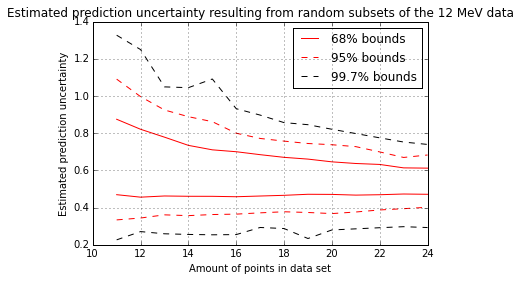

In [24]:
plot_intervals(x, y)
plt.grid(True)

plt.xlabel("Amount of points in data set")
plt.ylabel("Estimated prediction uncertainty")
plt.title("Estimated prediction uncertainty resulting from random subsets of the 12 MeV data")
plt.legend(["68% bounds", "95% bounds", "99.7% bounds"])

print("Number of data sets used = %d" %(len(x)))

bins = np.linspace(np.min(x)-0.5, np.max(x)+0.5, np.ptp(x)+2)
histogrammed, value = np.histogram(x, bins=bins)
histogrammed